# Project Overview
The ML-Driven Data Quality Validator is a tool designed to automate the detection and validation of data issues within datasets. By leveraging machine learning models and Python libraries, the tool identifies anomalies, missing values, and inconsistent patterns in data. This ensures the datasets conform to predefined quality standards, reducing errors and improving downstream data processing workflows.

# Key Features
1. Automated Data Profiling

  - Generate a summary of the dataset, including statistics like mean, median, standard deviation, null counts, and unique values.
  - Identify data type mismatches and formatting issues.
2. Rule-Based Validation

  - Incorporate custom rules for domain-specific data validation (e.g., date formats, ranges for numeric fields, or expected text patterns).
3. Anomaly Detection

  - Use machine learning algorithms to detect outliers and anomalies.
  - Examples:
    - K-Means for clustering-based anomaly detection.
    - Isolation Forest for identifying rare events or deviations.
4. Data Imputation Recommendations

  - Suggest imputation techniques for missing data (mean, median, mode, or predictive imputation using ML).
5. Validation Reports

  - Output results in clear, human-readable formats (e.g., HTML, with the ability to convert to PDF).
  - Highlight data quality metrics and detected issues.
6. Future Improvements - Scalability

  - Handle large datasets efficiently with Dask or Vaex if necessary.
  - Optionally integrate with cloud storage or databases for real-time validation.

## Installs

In [10]:
!pip install -q weasyprint

## Imports

In [284]:
import datetime
from dateutil.parser import parse
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from jinja2 import Template
import base64
from io import BytesIO

In [303]:
# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/maxemileffort/synthetic_healthcare_data/refs/heads/main/synthetic_healthcare_data.csv")

# Dictionary for dataset, to help with handling fields
data_dictionary = {
 'PatientID': {'Data Type': 'int64', 'Sub Data Type': 'id'},
 'Age': {'Data Type': 'int64', 'Sub Data Type': 'numeric'},
 'Gender': {'Data Type': 'object', 'Sub Data Type': 'string'},
 'AdmissionDate': {'Data Type': 'object', 'Sub Data Type': 'date'},
 'DischargeDate': {'Data Type': 'object', 'Sub Data Type': 'date'},
 'Diagnosis': {'Data Type': 'object', 'Sub Data Type': 'string'},
 'LabResult1': {'Data Type': 'float64', 'Sub Data Type': 'numeric'},
 'LabResult2': {'Data Type': 'float64', 'Sub Data Type': 'numeric'},
 'Medication': {'Data Type': 'object', 'Sub Data Type': 'string'},
 'Readmitted': {'Data Type': 'object', 'Sub Data Type': 'string'}
}

date_cols = [k for k,v in data_dictionary.items() if v['Sub Data Type'] == 'date']
num_cols = [k for k,v in data_dictionary.items() if v['Sub Data Type'] == 'numeric']
id_cols = [k for k,v in data_dictionary.items() if v['Sub Data Type'] == 'id']

# Initialize blank report data
report_data = {
    "profile_report": None,
    "rules_validation": None,
    "anomalies_count": None,
    "imputation_suggestions": None,
    "missing_values_plot": None,
    "non_numeric_distributions": None,
    "date_validation_html": None,
    "expected_values_report": None,
}

# Generate profiling report
def profile_data(df):
    profile = {
        "column_name": df.columns,
        "dtype": df.dtypes,
        "missing_values": df.isnull().sum(),
        "unique_values": df.nunique(),
        "mean": df.mean(numeric_only=True),
        "median": df.median(numeric_only=True),
        "std_dev": df.std(numeric_only=True),
    }
    return pd.DataFrame(profile)

profile_report = profile_data(df)

# Plot missing values as a bar chart
def plot_missing_values(df):
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]  # Filter columns with nulls
    if not null_counts.empty:
        plt.figure(figsize=(10, 6))
        null_counts.plot(kind="bar")
        plt.title("Missing Values per Column")
        plt.xlabel("Column Name")
        plt.ylabel("Number of Missing Values")
        plt.tight_layout()
        return save_plot_as_base64()
    return None

# Plot value distributions for non-numeric columns
def plot_non_numeric_distributions(df):
    plots = {}

    for column in df.columns:
        if column in id_cols:
            continue  # Skip ID columns
        # Check if the column is date-like
        elif column in date_cols:
            print(f"Date column detected: {column}")
            date_series = pd.to_datetime(df[column], errors="coerce", format='%Y-%m-%d')
            plt.figure(figsize=(10, 6))
            # Resample to months and count occurrences
            monthly_counts = date_series.dropna().dt.to_period("M").value_counts().sort_index()
            monthly_counts.plot(kind="bar")
            plt.title(f"Monthly Distribution: {column}")
            plt.xlabel("Month")
            plt.ylabel("Frequency")
            plt.tight_layout()
            plots[column] = save_plot_as_base64()
        elif column not in num_cols:
            # Fallback logic for non-date, non-numeric columns
            plt.figure(figsize=(10, 6))
            df[column].value_counts().plot(kind="bar")
            plt.title(f"Distribution of Values: {column}")
            plt.xlabel(column)
            plt.ylabel("Frequency")
            plt.tight_layout()
            plots[column] = save_plot_as_base64()

    return plots

# Save plots as Base64 to embed in the HTML report
def save_plot_as_base64():
    buf = BytesIO()
    plt.savefig(buf, format="png")
    plt.close()
    buf.seek(0)
    return base64.b64encode(buf.getvalue()).decode("utf-8")

# Generate plots
missing_values_plot = plot_missing_values(df)
non_numeric_distributions = plot_non_numeric_distributions(df)

print(profile_report)


Date column detected: AdmissionDate
Date column detected: DischargeDate
                 column_name    dtype  missing_values  unique_values  \
AdmissionDate      PatientID   object               0            200   
Age                      Age    int64               0             68   
Diagnosis             Gender   object               0              6   
DischargeDate  AdmissionDate   object               0            190   
Gender         DischargeDate   object               0              4   
LabResult1         Diagnosis  float64              20            180   
LabResult2        LabResult1  float64               0            191   
Medication        LabResult2   object              21              3   
PatientID         Medication    int64               0            200   
Readmitted        Readmitted   object               0              2   

                     mean      median    std_dev  
AdmissionDate         NaN         NaN        NaN  
Age             53.150000   53.50

In [304]:
df.head()

,PatientID,Age,Gender,AdmissionDate,DischargeDate,Diagnosis,LabResult1,LabResult2,Medication,Readmitted
0,1,69,Unknown,2023-01-01,2023-01-02,COVID-19,105.136854,7.096526,MedC,No
1,2,32,Male,2023-01-02,2023-01-03,Hypertension,128.672944,7.899181,MedA,No
2,3,89,Female,2023-01-03,2023-01-04,Healthy,104.793064,6.361718,MedB,No
3,4,78,Female,2023-01-04,2023-01-05,Hypertension,102.899171,7.381113,MedB,No
4,5,38,Male,2023-01-05,2023-01-06,Healthy,123.942144,4.086657,MedC,No


In [305]:
# Define validation rules
def validate_rules(df):
    rules_report = []
    for column in df.select_dtypes(include=["number"]).columns:
        invalid_negatives = (df[column] < 0).sum()
        rules_report.append({
            "column": column,
            "invalid_negatives": invalid_negatives
        })
    return pd.DataFrame(rules_report)

rules_validation = validate_rules(df)
print(rules_validation)

# Function to validate date columns
def validate_dates(df):
    # Check date sequencing if there are multiple date columns
    date_sequences = []
    if len(date_cols) > 1:
        for i, col1 in enumerate(date_cols):
            for j, col2 in enumerate(date_cols):
                if i < j:  # Compare only unique pairs
                    diff = pd.to_datetime(df[col2]) - pd.to_datetime(df[col1])
                    neg_diff = diff * -1  # Reverse the order
                    date_sequences.append({
                        "columns": (col1, col2),
                        "sequences_forward": (diff > pd.Timedelta(0)).sum(),
                        "sequences_backward": (neg_diff > pd.Timedelta(0)).sum(),
                    })
    return date_sequences

date_sequence_results = validate_dates(df)

# Placeholder for validating expected values
def validate_expected_values(df, expected_values):
    """
    Validate column entries against a predefined set of expected values.

    Args:
        df (pd.DataFrame): The input dataset.
        expected_values (dict): Dictionary where keys are column names and values are sets of expected values.
                                Example: {"column1": {"A", "B", "C"}, "column2": {1, 2, 3}}

    Returns:
        dict: A report of non-standard entries for each column.
    """
    # Uncomment and implement when expected values are available.
    # validation_report = {}
    # for column, valid_set in expected_values.items():
    #     if column in df.columns:
    #         invalid_values = df[~df[column].isin(valid_set)][column].unique()
    #         validation_report[column] = {"non_standard_values": invalid_values.tolist()}
    # return validation_report
    return None  # Placeholder for future functionality

# Example expected values placeholder
expected_values = {
    "CategoryColumn": {"Category1", "Category2", "Category3"},
    "NumericColumn": {1, 2, 3, 4, 5},
}
expected_values_report = validate_expected_values(df, expected_values)

# Integrate new results into the report
def integrate_date_validation_into_report(date_sequence_results):
    date_sequence_summary = "<h3>Date Sequencing Results</h3>"
    for result in date_sequence_results:
        col_pair = result["columns"]
        date_sequence_summary += f"<p>Columns {col_pair[0]} and {col_pair[1]}: Forward Sequences = {result['sequences_forward']}, Backward Sequences = {result['sequences_backward']}</p>"
    date_sequence_summary += "<br><p>Forward sequences are greater means the second date is later than the first.</p>"
    return date_sequence_summary

date_validation_html = integrate_date_validation_into_report(date_sequence_results)

       column  invalid_negatives
0   PatientID                  0
1         Age                  0
2  LabResult1                  0
3  LabResult2                  0


In [306]:
df.head()

,PatientID,Age,Gender,AdmissionDate,DischargeDate,Diagnosis,LabResult1,LabResult2,Medication,Readmitted
0,1,69,Unknown,2023-01-01,2023-01-02,COVID-19,105.136854,7.096526,MedC,No
1,2,32,Male,2023-01-02,2023-01-03,Hypertension,128.672944,7.899181,MedA,No
2,3,89,Female,2023-01-03,2023-01-04,Healthy,104.793064,6.361718,MedB,No
3,4,78,Female,2023-01-04,2023-01-05,Hypertension,102.899171,7.381113,MedB,No
4,5,38,Male,2023-01-05,2023-01-06,Healthy,123.942144,4.086657,MedC,No


In [307]:
# Select numerical columns and fill missing values
numerical_data = df.select_dtypes(include=["number"]).fillna(0)

# Standardize data for K-Means clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Train Isolation Forest
clf = IsolationForest(contamination=0.05, random_state=42)
df['isolation_forest_anomaly'] = clf.fit_predict(numerical_data)

# Train K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # 2 clusters: normal and anomalies
df['kmeans_cluster'] = kmeans.fit_predict(scaled_data)

# Determine the "anomalous" cluster in K-Means
# We assume the smaller cluster (by size) contains anomalies
cluster_sizes = df['kmeans_cluster'].value_counts()
anomaly_cluster = cluster_sizes.idxmin()
df['kmeans_anomaly'] = (df['kmeans_cluster'] == anomaly_cluster).astype(int) * -1 + 1  # Convert to -1 for consistency

# Combine results
df['combined_anomaly'] = (
    (df['isolation_forest_anomaly'] == -1) & (df['kmeans_anomaly'] == -1)
).astype(int)

# Separate anomalies
isolation_anomalies = df[df['isolation_forest_anomaly'] == -1]
kmeans_anomalies = df[df['kmeans_anomaly'] == -1]
combined_anomalies = df[df['combined_anomaly'] == 1]

# Unique anomalies for each method
iso_only_anomalies = isolation_anomalies[
    ~isolation_anomalies.index.isin(combined_anomalies.index)
]
kmeans_only_anomalies = kmeans_anomalies[
    ~kmeans_anomalies.index.isin(combined_anomalies.index)
]

# Print results
print(f"Anomalies detected by both methods: {len(combined_anomalies)}")
print(f"Anomalies detected only by Isolation Forest: {len(iso_only_anomalies)}")
print(f"Anomalies detected only by K-Means: {len(kmeans_only_anomalies)}")

Anomalies detected by both methods: 0
Anomalies detected only by Isolation Forest: 10
Anomalies detected only by K-Means: 0


In [308]:
# Recommend and perform imputations
def recommend_imputations(df):
    imputation_suggestions = {}
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            if df[column].dtype == "object":
                imputation_suggestions[column] = "Use Mode"
                # df[column].fillna(df[column].mode()[0], inplace=True)
            else:
                imputation_suggestions[column] = "Use Mean"
                # df[column].fillna(df[column].mean(), inplace=True)
    return imputation_suggestions

suggestions = recommend_imputations(df)
print(suggestions)


{'LabResult1': 'Use Mean', 'Medication': 'Use Mode'}


## Save as HTML / PDF

In [309]:
# Create CSS file that formats PDF
with open("styles.css", "w") as file:
  css_string = """
  body {
    font-family: Arial, sans-serif;
    margin: 0.1in; /* Adds margins to the entire page */
  }

  table {
      border-collapse: collapse;
      width: 100%; /* Ensures tables fit within the page width */
      table-layout: fixed; /* Prevents columns from expanding excessively */
      word-wrap: break-word; /* Breaks long text into multiple lines */
  }

  img { /* Ensures imgs fit within the page width */
      max-width: 100%;
      height: auto;
  }

  th, td {
      border: 1px solid #000;
      padding: 1px;
      text-align: left;
  }

  h1, h2, h3 {
      font-size: 1.2em;
      margin: 0.5em 0;
  }

  p {
      margin: 0.5em 0;
  }
"""
  file.write(css_string)

In [310]:
# Update data for the report
report_data = {
    "profile_report": profile_report.to_dict(orient="records"),
    "rules_validation": rules_validation.to_dict(orient="records"),
    "anomalies": [combined_anomalies, len(combined_anomalies)],
    "isolation_only_anomalies": [iso_only_anomalies, len(iso_only_anomalies)],
    "kmeans_only_anomalies": [kmeans_only_anomalies, len(kmeans_only_anomalies)],
    "imputation_suggestions": suggestions,
    "missing_values_plot": missing_values_plot,
    "non_numeric_distributions": non_numeric_distributions,
    "date_validation_html": date_validation_html,
    "expected_values_report": expected_values_report,
}


# Jinja2 template
html_template = """
<!DOCTYPE html>
<html>
<head>
<title>Data Quality Report</title>
<link rel="stylesheet" type="text/css" href="styles.css">
</head>
<body>
    <h1>Data Quality Report</h1>

    <h2>Profile Report</h2>
    <table border="1">
        <tr>
            <th>Column</th>
            <th>Data Type</th>
            <th>Missing Values</th>
            <th>Unique Values</th>
            <th>Mean</th>
            <th>Median</th>
            <th>Std Dev</th>
        </tr>
        {% for row in profile_report %}
        <tr>
            <td>{{ row.column_name }}</td>
            <td>{{ row.dtype }}</td>
            <td>{{ row.missing_values }}</td>
            <td>{{ row.unique_values }}</td>
            <td>{{ row.mean }}</td>
            <td>{{ row.median }}</td>
            <td>{{ row.std_dev }}</td>
        </tr>
        {% endfor %}
    </table>

    <h2>Validation Rules</h2>
    <h3>Total Anomalies Detected (Both Methods)</h3>
    <p>Count: {{ anomalies[1] }}</p>
    {% if anomalies[1] > 0 %}
    <table border="1">
        <tr>
            {% for col in anomalies[0].columns %}
            <th>{{ col }}</th>
            {% endfor %}
        </tr>
        {% for _, row in anomalies[0].iterrows() %}
        <tr>
            {% for col in anomalies[0].columns %}
            <td>{{ row[col] }}</td>
            {% endfor %}
        </tr>
        {% endfor %}
    </table>
    {% endif %}

    <h3>Anomalies Detected Only by Isolation Forest</h3>
    <p>Count: {{ isolation_only_anomalies[1] }}</p>
    {% if isolation_only_anomalies[1] > 0 %}
    <table border="1">
        <tr>
            {% for col in isolation_only_anomalies[0].columns %}
            <th>{{ col }}</th>
            {% endfor %}
        </tr>
        {% for _, row in isolation_only_anomalies[0].iterrows() %}
        <tr>
            {% for col in isolation_only_anomalies[0].columns %}
            <td>{{ row[col] }}</td>
            {% endfor %}
        </tr>
        {% endfor %}
    </table>
    {% endif %}

    <h3>Anomalies Detected Only by K-Means</h3>
    <p>Count: {{ kmeans_only_anomalies[1] }}</p>
    {% if kmeans_only_anomalies[1] > 0 %}
    <table border="1">
        <tr>
            {% for col in kmeans_only_anomalies[0].columns %}
            <th>{{ col }}</th>
            {% endfor %}
        </tr>
        {% for _, row in kmeans_only_anomalies[0].iterrows() %}
        <tr>
            {% for col in kmeans_only_anomalies[0].columns %}
            <td>{{ row[col] }}</td>
            {% endfor %}
        </tr>
        {% endfor %}
    </table>
    {% endif %}


    <h3>Imputation Suggestions</h3>
    <ul>
        {% for column, suggestion in imputation_suggestions.items() %}
        <li>{{ column }}: {{ suggestion }}</li>
        {% endfor %}
    </ul>

    <h2>Date Validations</h2>
    {{ date_validation_html }}

    {% if expected_values_report %}
    <h2>Expected Values</h2>
    {{ expected_values_report }}
    {% endif %}

    <h2>Missing Values</h2>
    {% if missing_values_plot %}
    <img src="data:image/png;base64,{{ missing_values_plot }}" alt="Missing Values Bar Chart">
    {% else %}
    <p>No missing values in the dataset.</p>
    {% endif %}

    <h2>Value Distributions</h2>
    {% for column, plot in non_numeric_distributions.items() %}
    <h3>{{ column }}</h3>
    <img src="data:image/png;base64,{{ plot }}" alt="Value Distribution for {{ column }}">
    {% endfor %}
</body>
</html>
"""

# Render and save the report
template = Template(html_template)
html_report = template.render(**report_data)

with open("data_quality_report.html", "w") as file:
    file.write(html_report)


In [311]:
from weasyprint import HTML, CSS

# Define the paths for the input HTML, CSS, and output PDF
html_file = "data_quality_report.html"
css_file = "styles.css"
pdf_file = "data_quality_report.pdf"

# Convert the HTML file to PDF with the CSS styling
HTML(html_file).write_pdf(pdf_file, stylesheets=[CSS(css_file)])

print(f"PDF report generated: {pdf_file}")

DEBUG:fontTools.ttLib.ttFont:Reading 'maxp' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'maxp' table
DEBUG:fontTools.subset.timer:Took 0.004s to load 'maxp'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'maxp'
INFO:fontTools.subset:maxp pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'cmap' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'cmap' table
DEBUG:fontTools.ttLib.ttFont:Reading 'post' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'post' table
DEBUG:fontTools.subset.timer:Took 0.010s to load 'cmap'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'cmap'
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:fpgm dropped
INFO:fontTools.subset:prep dropped
INFO:fontTools.subset:cvt  dropped
INFO:fontTools.subset:kern dropped
DEBUG:fontTools.subset.timer:Took 0.000s to load 'post'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'post'
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:GPOS dropped
INFO:fontTools.subset:GSUB dropped
DEBUG:f

PDF report generated: data_quality_report.pdf


To view the reports after running this notebook, on the very left side, there's some icons. Click the folder icon at the bottom:

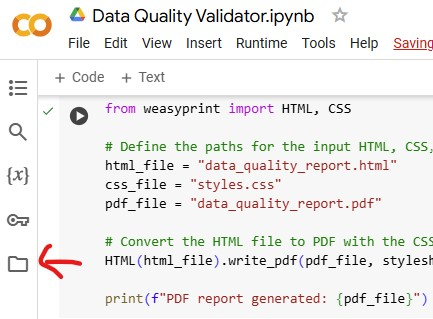

There will be 3 files in there:
- An HTML file
- A CSS files
- A PDF

You can download all 3 and open the HTML file and/or the PDF file to see the results.

Thanks for checking this out!